# Site and user analysis

Considering only sites with at least 5 updates that started since Jan 2013....
 - What percent of sites have posts from multiple userIds?
 - What percent of sites have posts from patients and caregivers?
 - What percent of users have posts on multiple sites?
 - What percent of users have posts from patients and caregivers?
 
 
#### Summary of results
 
Considering only the 99,021 CaringBridge sites created since January 2013 with more than 5 journal updates, 37% of sites contain updates from both patients and caregivers.  However, only 25% of sites contain updates authored by multiple registered CaringBridge _accounts_.

Of users who have authored updates for these selected sites, only a tiny minority author updates on more than one site: 1.32% author updates on multiple sites.  However, 30% of users have authored both patient and caregiver updates, which indicates potential multi-use of the account. 

#### Raw results
```
Sites with multiple authoring users: 51672 / 486704 = 10.62%
Sites with posts from patients AND caregivers: 129336 / 486704 = 26.57%
Users with authorship on multiple sites: 16437 / 524123 = 3.14%
Users with posts from patients AND caregivers: 133180 / 524123 = 25.41%

Selected 99021 / 486704 sites = 20.35%

Selected sites with multiple authoring users: 24350 / 99021 = 24.59%
Selected sites with posts from patients AND caregivers: 36775 / 99021 = 37.14%
Users (only on selected sites) with authorship on multiple sites: 1725 / 130399 = 1.32%
Users (only on selected sites) with posts from patients AND caregivers: 39427 / 130399 = 30.24%
```

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import re
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split

import itertools
from pprint import pprint
from collections import Counter, defaultdict
import sqlite3
from nltk import word_tokenize
from html.parser import HTMLParser
from tqdm import tqdm
import random
import pickle

from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl
from IPython.core.display import display, HTML

In [3]:
general_working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type"
vw_working_dir = os.path.join(general_working_dir, "vw")
os.makedirs(vw_working_dir, exist_ok=True)

In [4]:
#%%time
# read the dataframe
journal_df_filepath = os.path.join(vw_working_dir, "journal_author_metadata.csv")
journal_df = pd.read_csv(journal_df_filepath)
print(len(journal_df))

14970549


In [5]:
journal_df.head()

,Unnamed: 0,site_id,journal_oid,author_type_raw_prediction,author_type_prediction_prob,is_predicted_patient,created_at,site_index,user_id
0,7874,1,51bdf3e56ca0048f4e00ce76,-5.555666,0.003851,False,1117944720000,47,1
1,7876,1,51bdf3e56ca0048f4e00ce78,-4.185403,0.014988,False,1117764480000,46,1
2,7878,1,51bdf3e56ca0048f4e00ce7a,-2.417768,0.081828,False,1117675380000,45,1
3,7880,1,51bdf3e56ca0048f4e00ce7c,-3.126491,0.042028,False,1117572600000,44,1
4,7882,1,51bdf3e56ca0048f4e00ce7e,-2.294478,0.091581,False,1117485180000,43,1


In [6]:
j_df = journal_df

### Selected authors

In [7]:
auth_filepath = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/csv_data/cleaned_auths.csv"
auth_df = pd.read_csv(auth_filepath)
len(auth_df)

327445

In [8]:
auth_df.head()

,userId,num_journals,first_update,last_update,tenure
0,1,187,1103856900000,1261008420000,157151520000
1,2,29,1117053060000,1180149600000,63096540000
2,6,17,1112730300000,1372436275000,259705975000
3,4,2,1117605820000,1147748940000,30143120000
4,15,12,1117550400000,1222221120000,104670720000


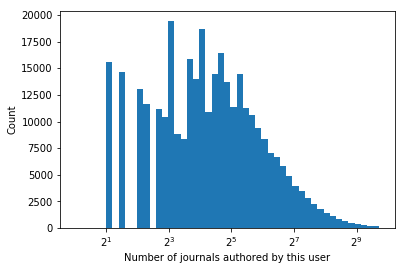

In [9]:
logbins = np.logspace(np.log2(1), np.log2(np.quantile(auth_df.num_journals, 0.999)), num=50, base=2, endpoint=True)
plt.hist(auth_df.num_journals, bins=logbins, log=False)
plt.xscale('log', nonposx='clip', basex=2)
plt.xlabel("Number of journals authored by this user")
plt.ylabel("Count")
plt.show()

In [10]:
valid_users = set(auth_df.userId)
len(valid_users)

327445

In [11]:
len(set(journal_df.user_id))

524123

In [12]:
subset_df = journal_df[~journal_df.user_id.isin(valid_users)]
len(subset_df), len(subset_df) / len(journal_df)

(2083671, 0.13918467519127053)

In [13]:
j_df = subset_df.reset_index(drop=True)
j_df.head()

,Unnamed: 0,site_id,journal_oid,author_type_raw_prediction,author_type_prediction_prob,is_predicted_patient,created_at,site_index,user_id
0,7736,30,51bdf3e56ca0048f4e00cde0,-2.141843,0.105096,False,1117652700000,1,32
1,11531,44,51bdf3e66ca0048f4e00df25,-2.377103,0.084935,False,1275396300000,269,0
2,11535,44,51bdf3e66ca0048f4e00df29,-1.991346,0.120115,False,1275587400000,271,0
3,11537,44,51bdf3e66ca0048f4e00df2b,-1.632288,0.163517,False,1276305480000,273,0
4,11543,44,51bdf3e66ca0048f4e00df31,-0.625347,0.348566,False,1277090160000,275,0


In [14]:
j_df.sort_values(by='user_id', inplace=True)

## User analysis

Includes all users and sites.

In [28]:
multiple_sites = 0
multiple_authors = 0
total_users = 0
for user, group in tqdm(j_df.groupby(by='user_id', sort=False)):
    total_users += 1
    site_ids = set(group.site_id)
    if len(site_ids) > 1:
        multiple_sites += 1
    proportion_patient = np.sum(group.is_predicted_patient) / len(group)
    if proportion_patient >= 0.1 and proportion_patient <= 0.9:
        multiple_authors += 1
total_users

100%|██████████| 196678/196678 [02:04<00:00, 1579.11it/s]


196678

In [29]:
print(f"Users with authorship on multiple sites: {multiple_sites} / {total_users} = {multiple_sites / total_users * 100:.2f}%")
print(f"Users with posts from patients AND caregivers: {multiple_authors} / {total_users} = {multiple_authors / total_users * 100:.2f}%")

Users with authorship on multiple sites: 3873 / 196678 = 1.97%
Users with posts from patients AND caregivers: 14229 / 196678 = 7.23%


## Site analysis

Analyzes all sites and users authoring for those sites.

In [27]:
jan_2013 = 1356998400000

In [30]:
multiple_users = 0
multiple_author_types = 0
total_sites = 0
selected_site_ids = set()
for site_id, group in tqdm(j_df.groupby(by='site_id', sort=False)):
    if len(group) >= 5:  # and np.min(group.created_at) >= jan_2013:
        selected_site_ids.add(site_id)
    total_sites += 1
    user_ids = set(group.user_id)
    if len(user_ids) > 1:
        multiple_users += 1
    proportion_patient = np.sum(group.is_predicted_patient) / len(group)
    if proportion_patient >= 0.1 and proportion_patient <= 0.9:
        multiple_author_types += 1
total_sites

100%|██████████| 201971/201971 [02:06<00:00, 1602.48it/s]


201971

In [31]:
print(f"Sites with multiple authoring users: {multiple_users} / {total_sites} = {multiple_users / total_sites * 100:.2f}%")
print(f"Sites with posts from patients AND caregivers: {multiple_author_types} / {total_sites} = {multiple_author_types / total_sites * 100:.2f}%")

Sites with multiple authoring users: 8323 / 201971 = 4.12%
Sites with posts from patients AND caregivers: 18377 / 201971 = 9.10%


In [32]:
print(f"Selected {len(selected_site_ids)} / {total_sites} sites = {len(selected_site_ids) / total_sites * 100:.2f}%")

Selected 38849 / 201971 sites = 19.23%


In [33]:
assert len(selected_site_ids) > 0

In [34]:
0 in selected_site_ids, 1 in selected_site_ids

(False, False)

## Multi-author site primary analysis

In [15]:
sites = set(journal_df[~journal_df.user_id.isin(valid_users)].site_id)
len(sites)

201971

In [16]:
valid_site_id_set = set(journal_df[journal_df.user_id.isin(valid_users)].site_id)
len(valid_site_id_set)

305892

In [17]:
valid_user_ids_set = set(valid_users)
len(valid_user_ids_set)

327445

In [18]:
0 in valid_user_ids_set

False

In [63]:
total_multiauthor_site_count = 0
multiple_selected_user_site_count = 0
unknown_primary_author = 0
user_counts_list = []
top_author_counts_list = []
multiauthor_site_ids = []
user_count_distributions_list = []
for site_id, group in tqdm(journal_df.groupby(by='site_id', sort=False)):
    user_ids = set(group.user_id)
    if 0 in user_ids:  # 0 is a special user_id that we take to indicate an unknown author
        user_ids.remove(0)
    if len(user_ids) > 1:
        total_multiauthor_site_count += 1
        multiauthor_site_ids.append(site_id)
        user_counts_list.append(len(user_ids))
        
        total_updates = len(group)
        user_id_counter = Counter(group.user_id)
        user_id, update_count = user_id_counter.most_common()[0]
        if user_id == 0:
            unknown_primary_author += 1
        
        user_count_distribution = [update_count for user_id, update_count in user_id_counter.most_common()
                                   if user_id != 0]
        user_count_distributions_list.append(user_count_distribution)
        
        if len(user_ids & valid_user_ids_set) > 1:
            multiple_selected_user_site_count += 1
        
        top_author_counts_list.append((update_count, total_updates))
    else:
        user_counts_list.append(1)
total_multiauthor_site_count

100%|██████████| 486704/486704 [03:00<00:00, 2697.59it/s]


44962

In [66]:
print(f"Warning: {unknown_primary_author} sites with an unknown primary author.")

In [67]:
print(f"{total_multiauthor_site_count} / {len(set(journal_df.site_id))} sites (that contain at least one update authored by a selected user) have 2+ authors.")
print(f"Of these {total_multiauthor_site_count} sites, {multiple_selected_user_site_count} sites have posts from multiple selected users.")

44962 / 486704 sites (that contain at least one update authored by a selected user) have 2+ authors.
Of these 44962 sites, 30212 sites have posts from multiple selected users.


In [59]:
# what percent of the journals are authored by user_id 0?
len(journal_df[journal_df.user_id == 0]) / len(journal_df)

0.07163918971842649

In [60]:
# what percent of sites contain an update authored by user_id 0?
len(set(journal_df[journal_df.user_id == 0].site_id)) / len(set(journal_df.site_id))

0.020092294289753114

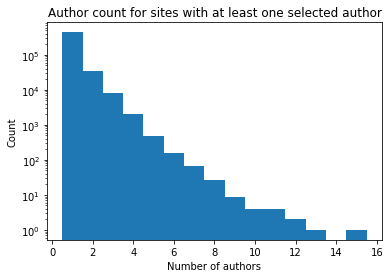

In [68]:
plt.hist(user_counts_list, log=True, bins=range(1, 17), align='left')
plt.xlabel("Number of authors")
plt.ylabel("Count")
plt.title("Author count for sites with at least one selected author")
plt.show()

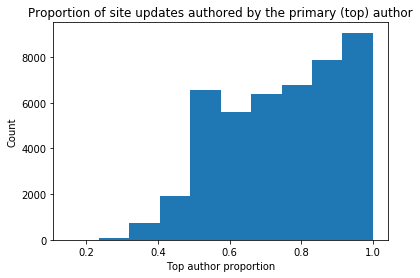

In [69]:
top_author_proportions = [authored_count / total_count for authored_count, total_count in top_author_counts_list]
plt.hist(top_author_proportions)
plt.xlabel("Top author proportion")
plt.ylabel("Count")
plt.title("Proportion of site updates authored by the primary (top) author")
plt.show()

In [70]:
u1 = []
u2 = []
u3 = []
for user_count_distribution in user_count_distributions_list:
    if len(user_count_distribution) != 3:
        continue
    total = np.sum(user_count_distribution)
    u1.append(user_count_distribution[0] / total)
    u2.append(user_count_distribution[1] / total)
    u3.append(user_count_distribution[2] / total)
np.mean(u1), np.mean(u2), np.mean(u3)

(0.6764074616312761, 0.23089503167013642, 0.09269750669858758)

In [72]:
for total_users in range(2, 7):
    user_proportions_lists = [[] for i in range(total_users)]
    total_sites_with_X_users = 0
    for user_count_distribution in user_count_distributions_list:
        if len(user_count_distribution) != total_users:
            continue
        total_sites_with_X_users += 1
        total = np.sum(user_count_distribution)
        for i in range(total_users):
            user_proportions_lists[i].append(user_count_distribution[i] / total)
    means = [np.mean(user_proportions) for user_proportions in user_proportions_lists]
    print("Site authors:", total_users)
    print(f"# sites: {total_sites_with_X_users}")
    for user_proportions in user_proportions_lists:
        print(f"{np.mean(user_proportions):.2f} +- {np.std(user_proportions):.2f} (max: {np.max(user_proportions):.2f})")
    print()


Site authors: 2
# sites: 34050
0.79 +- 0.15 (max: 1.00)
0.21 +- 0.15 (max: 0.50)

Site authors: 3
# sites: 8147
0.68 +- 0.16 (max: 1.00)
0.23 +- 0.12 (max: 0.49)
0.09 +- 0.07 (max: 0.33)

Site authors: 4
# sites: 2010
0.60 +- 0.16 (max: 0.99)
0.23 +- 0.10 (max: 0.46)
0.11 +- 0.07 (max: 0.32)
0.06 +- 0.04 (max: 0.25)

Site authors: 5
# sites: 486
0.54 +- 0.16 (max: 0.95)
0.23 +- 0.09 (max: 0.44)
0.12 +- 0.06 (max: 0.29)
0.07 +- 0.04 (max: 0.22)
0.04 +- 0.03 (max: 0.15)

Site authors: 6
# sites: 154
0.51 +- 0.16 (max: 0.94)
0.22 +- 0.08 (max: 0.41)
0.12 +- 0.06 (max: 0.26)
0.08 +- 0.05 (max: 0.19)
0.05 +- 0.03 (max: 0.14)
0.03 +- 0.02 (max: 0.09)



In [ ]:

for site_id, journals in tqdm(journal_df[journal_df.site_id.isin(multiauthor_site_ids)].groupby(by='site_id', sort=False)):
    # TODO do something with order for all multiauthor journals?


### Site index analysis

In [22]:
total_counts_by_site_index = defaultdict(int)
primary_author_counts_by_site_index = defaultdict(int)

for site_id, journals in tqdm(journal_df[journal_df.site_id.isin(multiauthor_site_ids)].groupby(by='site_id', sort=False)):
    author_count = len(set(journals.user_id))
    if author_count != 2:
        continue
    primary_author, primary_author_count = Counter(journals.user_id).most_common()[0]
    def increment_total_count(site_index):
        total_counts_by_site_index[site_index] += 1
    def increment_primary_count(site_index):
        primary_author_counts_by_site_index[site_index] += 1
    journals.site_index.map(increment_total_count)
    journals[journals.user_id == primary_author].site_index.map(increment_primary_count)

100%|██████████| 51672/51672 [01:29<00:00, 579.25it/s]


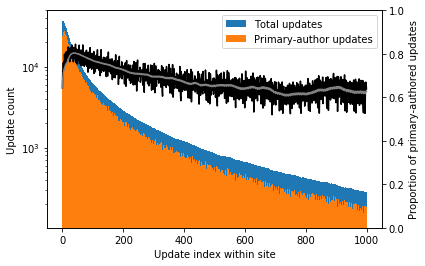

In [47]:
x = range(1000)
site_index_total_counts = np.array([total_counts_by_site_index[i] for i in x])
site_index_primary_counts = np.array([primary_author_counts_by_site_index[i] for i in x])

plt.bar(x, site_index_total_counts, label='Total updates', width=1, log=True)
plt.bar(x, site_index_primary_counts, label='Primary-author updates', width=1, log=True)

plt.xlabel("Update index within site")
plt.ylabel("Update count")

plt.legend()

ax = plt.twinx()
ax.plot(x, site_index_primary_counts / site_index_total_counts, color='black')
mean_vals = pd.Series(site_index_primary_counts / site_index_total_counts).rolling(20, min_periods=1).mean()
ax.plot(x, mean_vals, color='gray')

ax.set_ylim((0, 1))
ax.set_ylabel("Proportion of primary-authored updates")

plt.show()

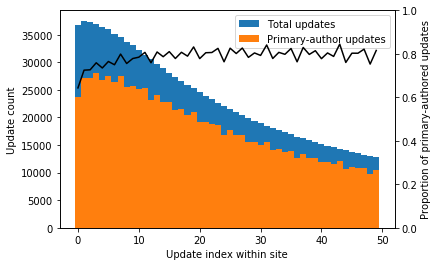

In [46]:
x = range(50)
site_index_total_counts = np.array([total_counts_by_site_index[i] for i in x])
site_index_primary_counts = np.array([primary_author_counts_by_site_index[i] for i in x])

plt.bar(x, site_index_total_counts, label='Total updates', width=1)
plt.bar(x, site_index_primary_counts, label='Primary-author updates', width=1)

plt.xlabel("Update index within site")
plt.ylabel("Update count")

plt.legend()

ax = plt.twinx()
ax.plot(x, site_index_primary_counts / site_index_total_counts, color='black')

ax.set_ylim((0, 1))
ax.set_ylabel("Proportion of primary-authored updates")

plt.show()

Taken together, the two figures above show that there is a relationship between update index within a site and the probability of it being authored by the site's primary author.  For most sites (with less than 50 updates), it seems as though the chance of a guest post being written _decreases_ over time.  For very long sites, it seems as though the chance of a guest post _increases_ over time, with a decline from 80% to 60% of a site's posts being authored by the primary author as the site index increases.  

Note that the above looks only at 2-author sites. The figures below repeat this analysis for 3+ author sites.

In [48]:
total_counts_by_site_index = defaultdict(int)
primary_author_counts_by_site_index = defaultdict(int)

for site_id, journals in tqdm(journal_df[journal_df.site_id.isin(multiauthor_site_ids)].groupby(by='site_id', sort=False)):
    author_count = len(set(journals.user_id))
    if author_count < 3:
        continue
    primary_author, primary_author_count = Counter(journals.user_id).most_common()[0]
    def increment_total_count(site_index):
        total_counts_by_site_index[site_index] += 1
    def increment_primary_count(site_index):
        primary_author_counts_by_site_index[site_index] += 1
    journals.site_index.map(increment_total_count)
    journals[journals.user_id == primary_author].site_index.map(increment_primary_count)

100%|██████████| 51672/51672 [00:43<00:00, 1177.11it/s]


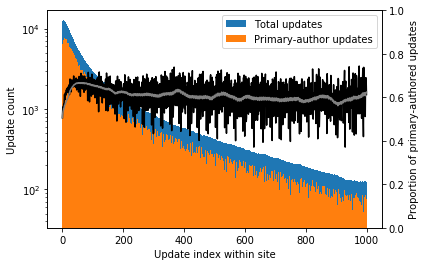

In [50]:
x = range(1000)
site_index_total_counts = np.array([total_counts_by_site_index[i] for i in x])
site_index_primary_counts = np.array([primary_author_counts_by_site_index[i] for i in x])

plt.bar(x, site_index_total_counts, label='Total updates', width=1, log=True)
plt.bar(x, site_index_primary_counts, label='Primary-author updates', width=1, log=True)

plt.xlabel("Update index within site")
plt.ylabel("Update count")

plt.legend()

ax = plt.twinx()
ax.plot(x, site_index_primary_counts / site_index_total_counts, color='black')
mean_vals = pd.Series(site_index_primary_counts / site_index_total_counts).rolling(20, min_periods=1).mean()
ax.plot(x, mean_vals, color='gray')

ax.set_ylim((0, 1))
ax.set_ylabel("Proportion of primary-authored updates")

plt.show()

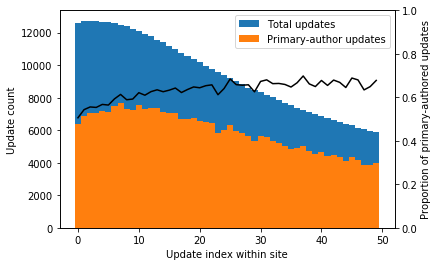

In [49]:
x = range(50)
site_index_total_counts = np.array([total_counts_by_site_index[i] for i in x])
site_index_primary_counts = np.array([primary_author_counts_by_site_index[i] for i in x])

plt.bar(x, site_index_total_counts, label='Total updates', width=1)
plt.bar(x, site_index_primary_counts, label='Primary-author updates', width=1)

plt.xlabel("Update index within site")
plt.ylabel("Update count")

plt.legend()

ax = plt.twinx()
ax.plot(x, site_index_primary_counts / site_index_total_counts, color='black')

ax.set_ylim((0, 1))
ax.set_ylabel("Proportion of primary-authored updates")

plt.show()

### Update time analysis

In [82]:
total_counts_by_day = defaultdict(int)
primary_author_counts_by_day = defaultdict(int)

for site_id, journals in tqdm(journal_df[journal_df.site_id.isin(multiauthor_site_ids)].groupby(by='site_id', sort=False)):
    
    author_count = len(set(journals.user_id))
    if author_count != 2:
        continue
    primary_author, primary_author_count = Counter(journals.user_id).most_common()[0]
    
    #ix = journals.created_at.idxmin()
    site_start = journals.created_at.min()
    
    def increment_total_count(created_at, site_start):
        ms_since_site_start = created_at - site_start
        days_since_site_start = np.floor(ms_since_site_start / 1000 / 60 / 60 / 24)
        total_counts_by_day[days_since_site_start] += 1
    def increment_primary_count(created_at, site_start):
        ms_since_site_start = created_at - site_start
        days_since_site_start = np.floor(ms_since_site_start / 1000 / 60 / 60 / 24)
        primary_author_counts_by_day[days_since_site_start] += 1
    journals.created_at.apply(increment_total_count, args=(site_start,))
    journals[journals.user_id == primary_author].created_at.apply(increment_primary_count, args=(site_start,))

100%|██████████| 44962/44962 [01:30<00:00, 495.28it/s] 


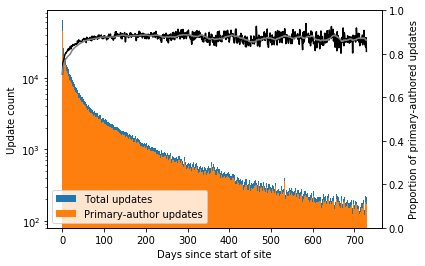

In [91]:
x = range(365 * 2)
day_total_counts = np.array([total_counts_by_day[i] for i in x])
day_primary_counts = np.array([primary_author_counts_by_day[i] for i in x])

plt.bar(x, day_total_counts, label='Total updates', width=1, log=True)
plt.bar(x, day_primary_counts, label='Primary-author updates', width=1, log=True)

plt.xlabel("Days since start of site")
plt.ylabel("Update count")

plt.legend(loc='lower left')

ax = plt.twinx()
ax.plot(x, day_primary_counts / day_total_counts, color='black')
mean_vals = pd.Series(day_primary_counts / day_total_counts).rolling(20, min_periods=1).mean()
ax.plot(x, mean_vals, color='gray')

ax.set_ylim((0, 1))
ax.set_ylabel("Proportion of primary-authored updates")

plt.show()

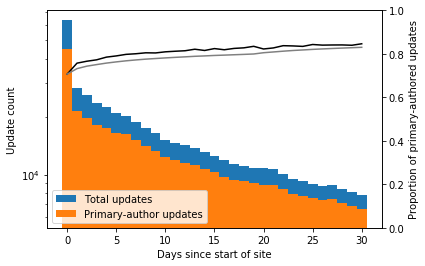

In [92]:
x = range(31)
day_total_counts = np.array([total_counts_by_day[i] for i in x])
day_primary_counts = np.array([primary_author_counts_by_day[i] for i in x])

plt.bar(x, day_total_counts, label='Total updates', width=1, log=True)
plt.bar(x, day_primary_counts, label='Primary-author updates', width=1, log=True)

plt.xlabel("Days since start of site")
plt.ylabel("Update count")

plt.legend(loc='lower left')

ax = plt.twinx()
ax.plot(x, day_primary_counts / day_total_counts, color='black')
mean_vals = pd.Series(day_primary_counts / day_total_counts).rolling(20, min_periods=1).mean()
ax.plot(x, mean_vals, color='gray')

ax.set_ylim((0, 1))
ax.set_ylabel("Proportion of primary-authored updates")

plt.show()

## Confidence analysis

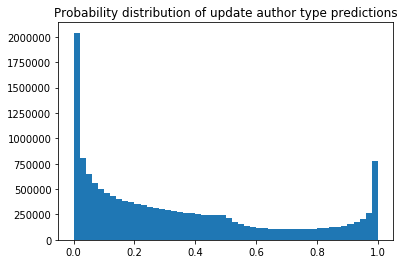

In [19]:
plt.hist(journal_df.author_type_prediction_prob, bins=50)
plt.title("Probability distribution of update author type predictions")
plt.show()

In [20]:
# want to estimate the probability of a site being shared vs primarily patient-authored vs primarily caregiver-authored
# Assumptions:
# (1) update classifications are independent within a site (which seems false)
# (2) the classifier is well-calibrated i.e. f(x) is approximately the probability of being patient-authored

In [49]:
all_patient_probs = []
all_caregiver_probs = []
patient_probs = []
caregiver_probs = []
shared_probs = []

# the naive labeling identifies a proportion of udpates that are patient-authored on a site using the 0.5 decision boundary
naive_labels = []

# total journal count, tracks the number of updates in each site computed
journal_update_counts = []
site_id_list = []

skipped_sites_count = 0

for site_id, journals in tqdm(journal_df[journal_df.site_id.isin(valid_site_id_set)].groupby(by='site_id', sort=False)):
    journal_count = len(journals)
    if journal_count > 5:
        skipped_sites_count += 1
        continue
    journal_update_counts.append(journal_count)
    site_id_list.append(site_id)
    probs = journals.author_type_prediction_prob.to_numpy()
    
    naive_proportion = np.sum(probs >= 0.5) / journal_count
    if naive_proportion >= 0.9:
        naive_label = 0
    elif naive_proportion > 0.1:
        naive_label = 1
    else:
        naive_label = 2
    naive_labels.append(naive_label)
    
    p_all_patient = np.prod(probs)
    p_all_caregiver = np.prod(1 - probs)
    
    p_patient = 0
    p_caregiver = 0
    p_shared = 0
    for index in itertools.product([False, True], repeat=journal_count):
        #assert len(index) == len(probs), f"{len(probs)}, {len(index)}"
        #print(probs, index)
        #print(probs[index])
        site_proportion = np.sum(index) / journal_count
        if site_proportion == 0:
            prob_patient = p_all_caregiver
        elif site_proportion == 1:
            prob_patient = p_all_patient
        else:
            #print(probs)
            #print(index)
            prob_patient = np.prod(np.append(
                probs[np.array(index)], 
                1 - probs[np.array([not i for i in index])]))
        
        site_proportion = np.sum(index) / journal_count
        if site_proportion >= 0.9:
            p_patient += prob_patient
        elif site_proportion > 0.1:
            p_shared += prob_patient
        else:
            p_caregiver += prob_patient
    
    all_patient_probs.append(p_all_patient)
    all_caregiver_probs.append(p_all_caregiver)
    patient_probs.append(p_patient)
    caregiver_probs.append(p_caregiver)
    shared_probs.append(p_shared)
len(journal_update_counts)


 10%|▉         | 29580/305892 [01:19<11:21, 405.29it/s]

  0%|          | 0/305892 [00:00<?, ?it/s]

  0%|          | 1/305892 [00:01<85:02:54,  1.00s/it]

  0%|          | 257/305892 [00:01<59:29:38,  1.43it/s]

  0%|          | 531/305892 [00:01<41:37:04,  2.04it/s]

  0%|          | 785/305892 [00:01<29:07:05,  2.91it/s]

  0%|          | 1068/305892 [00:01<20:22:22,  4.16it/s]

  0%|          | 1342/305892 [00:01<14:15:26,  5.93it/s]

  1%|          | 1632/305892 [00:01<9:58:46,  8.47it/s] 

  1%|          | 1919/305892 [00:01<6:59:16, 12.08it/s]

  1%|          | 2185/305892 [00:01<4:53:48, 17.23it/s]

  1%|          | 2444/305892 [00:01<3:26:05, 24.54it/s]

  1%|          | 2738/305892 [00:02<2:24:38, 34.93it/s]

  1%|          | 3027/305892 [00:02<1:41:40, 49.65it/s]

  1%|          | 3325/305892 [00:02<1:11:36, 70.42it/s]

  1%|          | 3626/305892 [00:02<50:34, 99.60it/s]  

  1%|▏         | 3925/305892 [00:02<35:52, 140.28it/s]

  1%|▏         | 4216/305892 [00:02<25:37, 

 12%|█▏        | 36860/305892 [00:13<01:30, 2972.53it/s]

 12%|█▏        | 37158/305892 [00:14<01:32, 2897.42it/s]

 12%|█▏        | 37449/305892 [00:14<01:32, 2890.72it/s]

 12%|█▏        | 37739/305892 [00:14<01:33, 2859.03it/s]

 12%|█▏        | 38026/305892 [00:14<01:36, 2768.01it/s]

 13%|█▎        | 38304/305892 [00:14<01:36, 2764.07it/s]

 13%|█▎        | 38629/305892 [00:14<01:32, 2893.22it/s]

 13%|█▎        | 38927/305892 [00:14<01:31, 2917.46it/s]

 13%|█▎        | 39226/305892 [00:14<01:30, 2938.04it/s]

 13%|█▎        | 39531/305892 [00:14<01:29, 2970.06it/s]

 13%|█▎        | 39829/305892 [00:14<01:30, 2936.49it/s]

 13%|█▎        | 40124/305892 [00:15<01:31, 2899.05it/s]

 13%|█▎        | 40415/305892 [00:15<01:32, 2870.27it/s]

 13%|█▎        | 40714/305892 [00:15<01:31, 2899.29it/s]

 13%|█▎        | 41012/305892 [00:15<01:30, 2921.65it/s]

 14%|█▎        | 41320/305892 [00:15<01:29, 2965.97it/s]

 14%|█▎        | 41617/305892 [00:15<01:30, 2905.94it/s]

 14%|█▎       

 24%|██▍       | 74647/305892 [00:27<01:19, 2898.10it/s]

 25%|██▍       | 74954/305892 [00:27<01:18, 2946.32it/s]

 25%|██▍       | 75262/305892 [00:27<01:17, 2984.20it/s]

 25%|██▍       | 75563/305892 [00:27<01:17, 2990.25it/s]

 25%|██▍       | 75863/305892 [00:27<01:16, 2990.00it/s]

 25%|██▍       | 76177/305892 [00:27<01:15, 3030.24it/s]

 25%|██▌       | 76481/305892 [00:27<01:17, 2945.53it/s]

 25%|██▌       | 76777/305892 [00:27<01:19, 2867.53it/s]

 25%|██▌       | 77065/305892 [00:27<01:22, 2761.35it/s]

 25%|██▌       | 77343/305892 [00:27<01:23, 2728.78it/s]

 25%|██▌       | 77640/305892 [00:28<01:21, 2796.68it/s]

 25%|██▌       | 77954/305892 [00:28<01:18, 2889.95it/s]

 26%|██▌       | 78246/305892 [00:28<01:18, 2897.18it/s]

 26%|██▌       | 78537/305892 [00:28<01:19, 2846.84it/s]

 26%|██▌       | 78845/305892 [00:28<01:17, 2911.07it/s]

 26%|██▌       | 79138/305892 [00:28<01:19, 2857.35it/s]

 26%|██▌       | 79425/305892 [00:28<01:20, 2818.64it/s]

 26%|██▌      

 37%|███▋      | 112199/305892 [00:40<01:10, 2751.64it/s]

 37%|███▋      | 112475/305892 [00:40<01:11, 2720.48it/s]

 37%|███▋      | 112755/305892 [00:40<01:10, 2739.15it/s]

 37%|███▋      | 113030/305892 [00:40<01:10, 2724.61it/s]

 37%|███▋      | 113303/305892 [00:40<01:10, 2713.17it/s]

 37%|███▋      | 113622/305892 [00:40<01:07, 2838.73it/s]

 37%|███▋      | 113908/305892 [00:40<01:07, 2827.71it/s]

 37%|███▋      | 114192/305892 [00:40<01:07, 2825.99it/s]

 37%|███▋      | 114476/305892 [00:40<01:08, 2794.41it/s]

 38%|███▊      | 114773/305892 [00:40<01:07, 2844.71it/s]

 38%|███▊      | 115059/305892 [00:41<01:07, 2840.87it/s]

 38%|███▊      | 115345/305892 [00:41<01:06, 2845.55it/s]

 38%|███▊      | 115630/305892 [00:41<01:06, 2845.82it/s]

 38%|███▊      | 115928/305892 [00:41<01:05, 2883.83it/s]

 38%|███▊      | 116223/305892 [00:41<01:05, 2901.40it/s]

 38%|███▊      | 116514/305892 [00:41<01:07, 2814.80it/s]

 38%|███▊      | 116804/305892 [00:41<01:06, 2838.88it/s

 49%|████▊     | 148569/305892 [00:52<00:57, 2743.12it/s]

 49%|████▊     | 148845/305892 [00:53<00:58, 2706.07it/s]

 49%|████▊     | 149117/305892 [00:53<00:58, 2689.00it/s]

 49%|████▉     | 149400/305892 [00:53<00:57, 2726.36it/s]

 49%|████▉     | 149703/305892 [00:53<00:55, 2809.90it/s]

 49%|████▉     | 149996/305892 [00:53<00:54, 2843.33it/s]

 49%|████▉     | 150282/305892 [00:53<00:55, 2815.91it/s]

 49%|████▉     | 150565/305892 [00:53<00:55, 2803.74it/s]

 49%|████▉     | 150846/305892 [00:53<00:56, 2727.52it/s]

 49%|████▉     | 151120/305892 [00:53<00:57, 2713.22it/s]

 49%|████▉     | 151415/305892 [00:53<00:55, 2775.02it/s]

 50%|████▉     | 151694/305892 [00:54<00:56, 2735.56it/s]

 50%|████▉     | 151979/305892 [00:54<00:55, 2768.83it/s]

 50%|████▉     | 152258/305892 [00:54<00:55, 2773.74it/s]

 50%|████▉     | 152536/305892 [00:54<00:55, 2758.40it/s]

 50%|████▉     | 152813/305892 [00:54<00:55, 2759.79it/s]

 50%|█████     | 153090/305892 [00:54<00:56, 2717.14it/s

 60%|██████    | 184611/305892 [01:05<00:42, 2846.03it/s]

 60%|██████    | 184897/305892 [01:05<00:43, 2808.14it/s]

 61%|██████    | 185182/305892 [01:06<00:42, 2819.70it/s]

 61%|██████    | 185465/305892 [01:06<00:43, 2772.31it/s]

 61%|██████    | 185760/305892 [01:06<00:42, 2821.84it/s]

 61%|██████    | 186043/305892 [01:06<00:43, 2775.51it/s]

 61%|██████    | 186344/305892 [01:06<00:42, 2840.78it/s]

 61%|██████    | 186629/305892 [01:06<00:42, 2809.07it/s]

 61%|██████    | 186911/305892 [01:06<00:42, 2804.30it/s]

 61%|██████    | 187192/305892 [01:06<00:42, 2761.91it/s]

 61%|██████▏   | 187475/305892 [01:06<00:42, 2780.88it/s]

 61%|██████▏   | 187754/305892 [01:07<00:43, 2716.67it/s]

 61%|██████▏   | 188042/305892 [01:07<00:42, 2752.11it/s]

 62%|██████▏   | 188318/305892 [01:07<00:42, 2746.59it/s]

 62%|██████▏   | 188594/305892 [01:07<00:43, 2702.16it/s]

 62%|██████▏   | 188865/305892 [01:07<00:43, 2662.64it/s]

 62%|██████▏   | 189132/305892 [01:07<00:44, 2624.47it/s

 72%|███████▏  | 219951/305892 [01:18<00:31, 2769.88it/s]

 72%|███████▏  | 220229/305892 [01:19<00:30, 2765.93it/s]

 72%|███████▏  | 220507/305892 [01:19<00:31, 2720.28it/s]

 72%|███████▏  | 220792/305892 [01:19<00:30, 2752.50it/s]

 72%|███████▏  | 221068/305892 [01:19<00:31, 2731.50it/s]

 72%|███████▏  | 221342/305892 [01:19<00:31, 2727.11it/s]

 72%|███████▏  | 221632/305892 [01:19<00:30, 2774.64it/s]

 73%|███████▎  | 221912/305892 [01:19<00:30, 2781.16it/s]

 73%|███████▎  | 222191/305892 [01:19<00:30, 2743.19it/s]

 73%|███████▎  | 222471/305892 [01:19<00:30, 2758.18it/s]

 73%|███████▎  | 222748/305892 [01:19<00:30, 2718.50it/s]

 73%|███████▎  | 223021/305892 [01:20<00:31, 2665.67it/s]

 73%|███████▎  | 223289/305892 [01:20<00:31, 2637.84it/s]

 73%|███████▎  | 223588/305892 [01:20<00:30, 2734.30it/s]

 73%|███████▎  | 223863/305892 [01:20<00:29, 2736.32it/s]

 73%|███████▎  | 224138/305892 [01:20<00:30, 2687.85it/s]

 73%|███████▎  | 224436/305892 [01:20<00:29, 2766.10it/s

 83%|████████▎ | 254389/305892 [01:31<00:19, 2703.70it/s]

 83%|████████▎ | 254668/305892 [01:31<00:18, 2728.18it/s]

 83%|████████▎ | 254942/305892 [01:32<00:19, 2628.64it/s]

 83%|████████▎ | 255207/305892 [01:32<00:19, 2592.15it/s]

 84%|████████▎ | 255484/305892 [01:32<00:19, 2641.88it/s]

 84%|████████▎ | 255750/305892 [01:32<00:19, 2565.14it/s]

 84%|████████▎ | 256012/305892 [01:32<00:19, 2570.62it/s]

 84%|████████▍ | 256286/305892 [01:32<00:18, 2617.42it/s]

 84%|████████▍ | 256549/305892 [01:32<00:19, 2596.35it/s]

 84%|████████▍ | 256810/305892 [01:32<00:19, 2566.21it/s]

 84%|████████▍ | 257068/305892 [01:32<00:19, 2523.05it/s]

 84%|████████▍ | 257324/305892 [01:32<00:19, 2532.97it/s]

 84%|████████▍ | 257596/305892 [01:33<00:18, 2585.68it/s]

 84%|████████▍ | 257858/305892 [01:33<00:18, 2593.52it/s]

 84%|████████▍ | 258118/305892 [01:33<00:18, 2588.85it/s]

 84%|████████▍ | 258409/305892 [01:33<00:17, 2675.98it/s]

 85%|████████▍ | 258678/305892 [01:33<00:17, 2638.13it/s

 94%|█████████▎| 286445/305892 [01:44<00:08, 2385.86it/s]

 94%|█████████▎| 286684/305892 [01:44<00:08, 2314.11it/s]

 94%|█████████▍| 286943/305892 [01:45<00:07, 2390.32it/s]

 94%|█████████▍| 287184/305892 [01:45<00:08, 2326.85it/s]

 94%|█████████▍| 287418/305892 [01:45<00:08, 2290.77it/s]

 94%|█████████▍| 287649/305892 [01:45<00:07, 2284.68it/s]

 94%|█████████▍| 287890/305892 [01:45<00:07, 2319.52it/s]

 94%|█████████▍| 288125/305892 [01:45<00:07, 2324.49it/s]

 94%|█████████▍| 288358/305892 [01:45<00:07, 2317.00it/s]

 94%|█████████▍| 288614/305892 [01:45<00:07, 2382.98it/s]

 94%|█████████▍| 288853/305892 [01:45<00:07, 2382.18it/s]

 95%|█████████▍| 289102/305892 [01:45<00:06, 2413.33it/s]

 95%|█████████▍| 289344/305892 [01:46<00:06, 2371.51it/s]

 95%|█████████▍| 289582/305892 [01:46<00:06, 2361.35it/s]

 95%|█████████▍| 289819/305892 [01:46<00:06, 2331.48it/s]

 95%|█████████▍| 290053/305892 [01:46<00:06, 2330.26it/s]

 95%|█████████▍| 290287/305892 [01:46<00:06, 2294.77it/s

47183

In [50]:
# we are representing this % of sites in the analysis
# and specifically the smallest sites
len(journal_update_counts) / (skipped_sites_count + len(journal_update_counts))

0.15424725066363293

In [51]:
# verify the outputs
for i in range(len(patient_probs)):
    assert np.isclose(1, patient_probs[i] + shared_probs[i] + caregiver_probs[i])

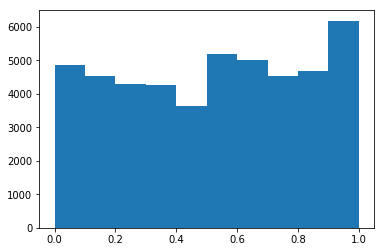

In [52]:
# plot the confusion
c = []
for i in range(len(patient_probs)):
    p_patient = patient_probs[i]  
    p_shared = shared_probs[i]
    p_caregiver = caregiver_probs[i]
    m = np.max([p_patient, p_shared, p_caregiver])
    diffs = np.array([
        m - p_shared,
        m - p_caregiver,
        m - p_shared
    ])
    confusion = np.min(diffs[np.nonzero(diffs)])
    c.append(confusion)

plt.hist(c)
plt.show()

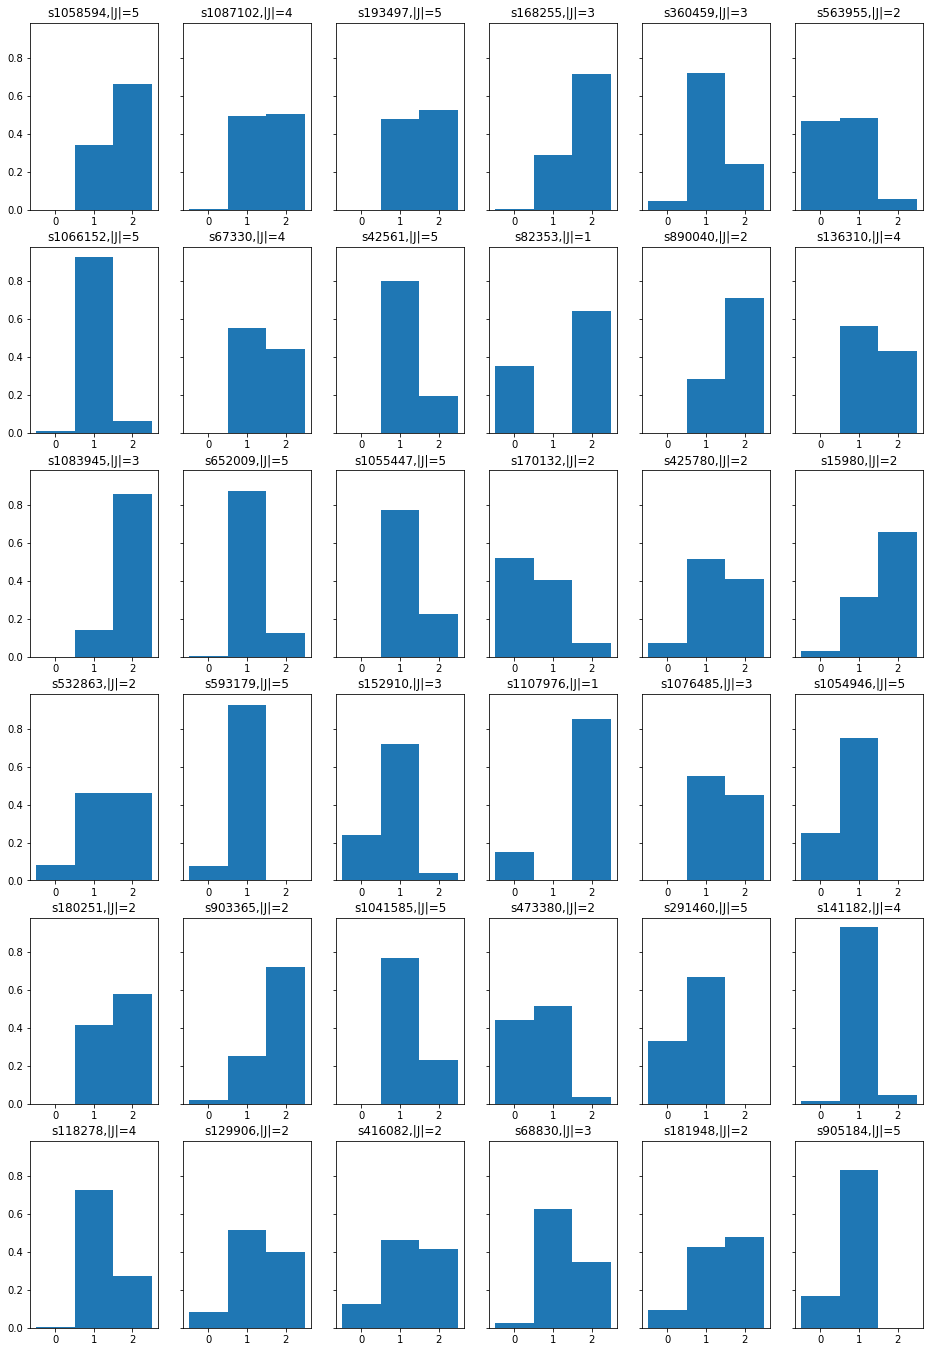

In [55]:
# random sample of site probabilities
fig, axes = plt.subplots(6, 6, figsize=(16, 24), squeeze=True, sharey=True)
for ax, ix in zip(np.array(axes).flatten(), np.random.choice(len(patient_probs), 6 * 6)):
    ax.bar(range(3), [patient_probs[ix], shared_probs[ix], caregiver_probs[ix]], width=1)
    ax.set_title(f"s{site_id_list[ix]},|J|={journal_update_counts[ix]}")
plt.show()

In [38]:
np.random.choice(len(patient_probs))

60785

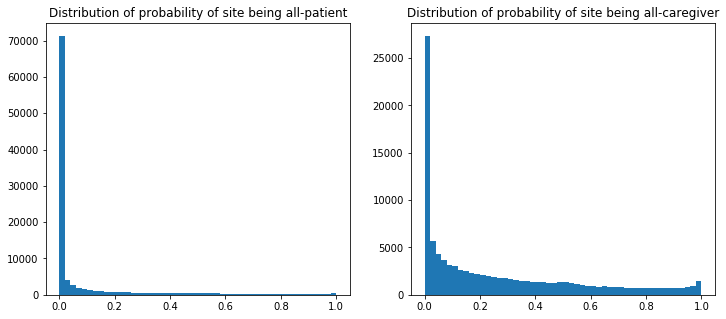

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ax = axes[0]
ax.hist(all_patient_probs, bins=50)
ax.set_title("Distribution of probability of site being all-patient")
ax = axes[1]
ax.hist(all_caregiver_probs, bins=50)
ax.set_title("Distribution of probability of site being all-caregiver")
plt.show()

In [27]:
# what percentage of sites have a greater than 50% probability of being all-patient?
np.sum(np.array(all_patient_probs) >= 0.5) / len(all_patient_probs)

0.07049995127180586

In [28]:
# what percentage of sites have a greater than 50% probability of being all-caregiver?
np.sum(np.array(all_caregiver_probs) >= 0.5) / len(all_caregiver_probs)

0.2151447227365754

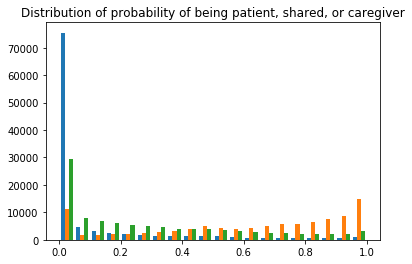

In [29]:
plt.hist([patient_probs, shared_probs, caregiver_probs], bins=20)
plt.title("Distribution of probability of being patient, shared, or caregiver")
plt.show()

In [30]:
labels = []
for i in range(len(patient_probs)):
    if patient_probs[i] > shared_probs[i] and patient_probs[i] > caregiver_probs[i]:
        label = 0
    elif shared_probs[i] > patient_probs[i] and shared_probs[i] > caregiver_probs[i]:
        label = 1
    elif caregiver_probs[i] > shared_probs[i] and caregiver_probs[i] > patient_probs[i]:
        label = 2
    else:
        raise Exception("Check conditional logic.")
    labels.append(label)
labels = np.array(labels)

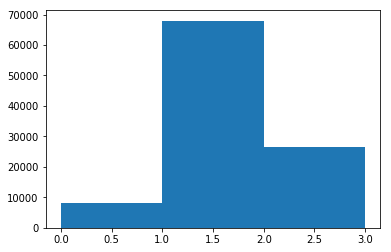

In [31]:
plt.hist(labels, bins=range(4))
plt.show()

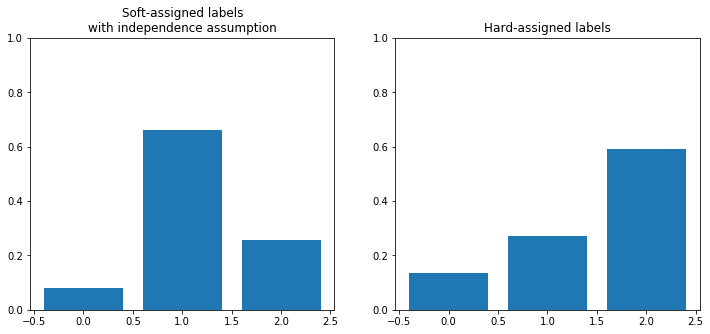

[0.07996296657245883, 0.6625572556281064, 0.25747977779943476]
[0.1370626644576552, 0.27255628106422375, 0.5903810544781211]


In [32]:
t = len(patient_probs)
y = [np.sum(labels==0) / t, np.sum(labels==1) / t, np.sum(labels==2) / t]
naive_labels_np = np.array(naive_labels)
naive_y = [np.sum(naive_labels_np==0) / t, np.sum(naive_labels_np==1) / t, np.sum(naive_labels_np==2) / t]
fix, axes = plt.subplots(1, 2, figsize=(12, 5))
labels = []
ax = axes[0]
ax.bar([0, 1, 2], y)
ax.set_ylim((0, 1))
ax.set_title("Soft-assigned labels\nwith independence assumption")
ax = axes[1]
ax.bar([0, 1, 2], naive_y)
ax.set_ylim((0, 1))
ax.set_title("Hard-assigned labels")
plt.show()
pprint(y)
pprint(naive_y)

In [33]:
len(list(itertools.product([False, True], repeat=15)))

32768